In [2]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from sklearn.metrics import *

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from model import *

import matplotlib.pyplot as plt
import seaborn as sns

## Preparing Dataset

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0
start_epoch = 0

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # # best practice for normalization
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=16)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


## Resnet-18 + flipped data checkpoint

In [4]:
print('==> Building model..')

net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

checkpoint = torch.load('./../checkpoint-basicnorm/ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

==> Building model..


In [5]:
criterion = nn.CrossEntropyLoss()
label_report = []
pred_report = []

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            label_report.extend(targets.tolist())
            pred_report.extend(predicted.tolist())

        print(classification_report(label_report, pred_report, target_names=classes))

In [6]:
torch.multiprocessing.freeze_support()
test(0)

              precision    recall  f1-score   support

       plane       0.89      0.92      0.91      1000
         car       0.95      0.96      0.96      1000
        bird       0.89      0.83      0.86      1000
         cat       0.77      0.80      0.79      1000
        deer       0.90      0.90      0.90      1000
         dog       0.84      0.84      0.84      1000
        frog       0.91      0.94      0.92      1000
       horse       0.95      0.91      0.93      1000
        ship       0.94      0.94      0.94      1000
       truck       0.94      0.95      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Confusion Matrix

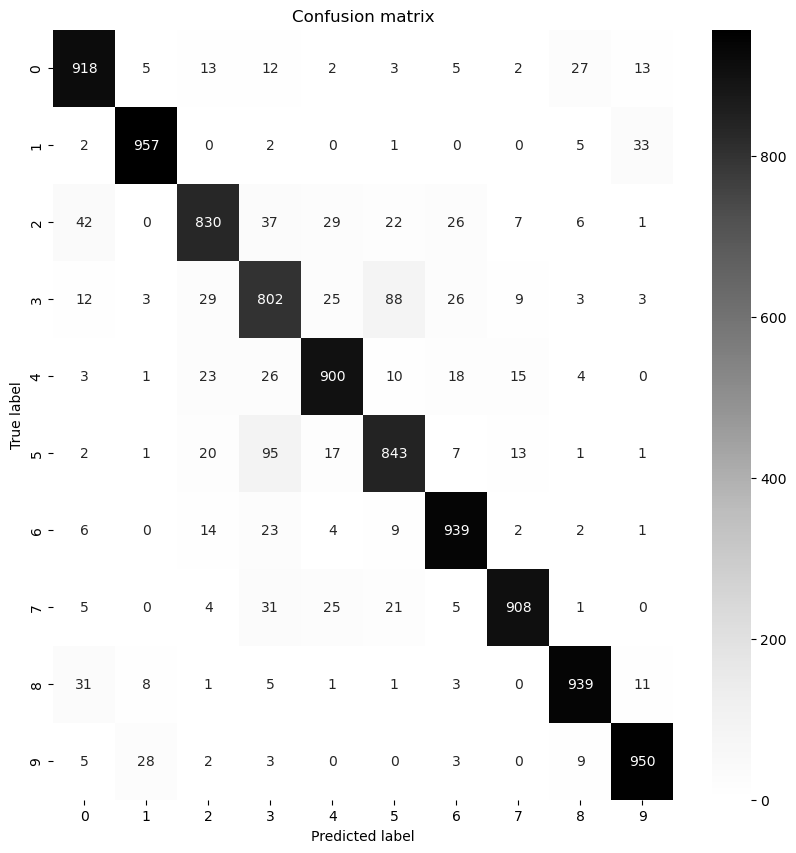

In [7]:
cm = confusion_matrix(label_report, pred_report)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greys')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()